# League of Legends 10 Minute Game Analysis

This notebook explores the [League of Legends Diamond-Ranked Games](https://www.kaggle.com/bobbyscience/league-of-legends-diamond-ranked-games-10-min) dataset on Kaggle. 
The core feature of the dataset is `blueWins`, which is a binary variable indicating which team won (0 means red team wins, and 1 means blue team wins). The dataset features about 10,000 games between diamond-ranked players, and all data comes from the first 10 minutes of gameplay. A typical game can last between 20 and 40 minutes, so the cutoff of 10 minutes produces an interesting binary classification problem.

## Game Rundown

League of Legends is a game developed by Riot Games, and in recent years has become a very popular eSport. 
If you are unfamiliar with League of Legends, here is a very brief breakdown of gameplay.

<figure>
    <img src="img/lol_map.jpg" alt="League of Legends map" width="500"/>
    <center>
        The arena where games of League of Legends takes place. (Source: 
        <a href=https://leagueoflegends.fandom.com/wiki/Map_(League_of_Legends)> League of Legends Wiki)</a>
    </center>
</figure>

* There are two teams, red team and blue team, that fight each other attempting to destroy each other's buildings. A team wins when the other team's core building, the "nexus," is destroyed.

* Players control a single unit, dubbed their "champion." Champions can level up over the course of the game and earn gold to buy better equipment. Gold is mainly obtained by killing enemy minions (lower-level monsters that continually spawn) and enemy champions, though there are other sources.

Here is some terminology to help understand the dataset:

* **minions**: these are small, easy to kill monsters that continually spawn in waves. Killing them awards gold _only if_ a champion makes the final hit on the minion. The number of minions killed by champions with a last hit is referred to as **creep score (CS)**.

* **towers**: these are stationary turrets that will attack enemies. Both teams start with 11. Destroying these rewards a team with gold.

* **jungle**: this is the region in the middle of the map away from the three lanes. There are also neutral minions that spawn here that reward gold when slain.

* **elite monsters**: this includes **dragons** and **rift heralds** in this dataset. (There are others, but they show up after the 10 minute mark). These are strong monsters that, when slain, award gold and buffs to champions on the team that slays the monster. In this dataset, the features `blueEliteMonsters` and `redEliteMonsters` are the sum of the number of dragons and heralds slain.

* **wards**: these are tiny structures that provide vision around them to their team. A champion can place them around the map so they can see what is going on when nobody on their team is in the vicinity. Teams can destroy the enemy team's wards.

* **first blood**: the first champion death of the game.

## Dataset Information

There are 9,879 games (observations) in this dataset and 39 features. 
Almost every metric has a feature for both red and blue teams. There are 19 metrics, which are

* **wardsPlaced**: total number of wards placed throughout the 10 minutes.
* **wardsDestroyed**: how many wards are destroyed. 
* **firstBlood**: 0 or 1 indicating if the team got the first kill of the game
* **Kills**: number of champion kills
* **Deaths**: number of deaths. 
* **Assists**: number of assists.
* **Dragons**: number of dragons slain.
* **Heralds**: number of heralds slain.
* **Elite Monsters**: number of dragons and heralds killed combined.
* **TowersDestroyed**: number of towers destroyed by the team.
* **TotalGold**: amount of gold obtained from all sources.
* **AverageLevel**: average level of all champions at the 10 minute mark.
* **TotalExperience**: total experience gained from all champions on a team
* **TotalMinionsKilled**: number of minions killed by the team.
* **TotalJungleMinionsKilled**: number of jungle minions killed.
* **GoldDiff**: Difference in gold between the teams at the 10 minute mark.
* **CSPerMin**: Number of minion kills per minute.
* **GoldPerMin**: average gold per minute. This is the total gold obtained by the 10 minute mark divided by 10 minutes.
* **ExperienceDiff**: Difference in experience between the teams by the 10 minute mark.

Each of these has a prefix of `red` or `blue` to indicate which team is measured, giving 38 features. We get all of the features when we include `blueWins`, which does not have a `red` counterpart.

Note that some of these metrics are redundant. For example, `TotalGold` and `GoldPerMin` are directly related by a factor of 10 minutes. These redundancies will be explored and dealt with below.

In [81]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns 
import scipy

# sklearn preprocessing/scoring
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, KFold

#sklearn models 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

# for rendering html
from IPython.display import display, HTML

pd.set_option('display.max_columns', 50)

# Exploratory Data Analysis

Let's start by looking at the dataset and each feature's distribution. This will give us an idea of any outliers or class balance problems.

In [82]:
lol = pd.read_csv("./high_diamond_ranked_10min.csv", index_col=0)

In [83]:
lol.head()

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
gameId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4519157822,0,28,2,1,9,6,11,0,0,0,0,17210,6.6,17039,195,36,643,-8,19.5,1721.0,15,6,0,6,9,8,0,0,0,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
4523371949,0,12,1,0,5,5,5,0,0,0,0,14712,6.6,16265,174,43,-2908,-1173,17.4,1471.2,12,1,1,5,5,2,2,1,1,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
4521474530,0,15,0,0,7,11,4,1,1,0,0,16113,6.4,16221,186,46,-1172,-1033,18.6,1611.3,15,3,1,11,7,14,0,0,0,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
4524384067,0,43,1,0,4,5,5,1,0,1,0,15157,7.0,17954,201,55,-1321,-7,20.1,1515.7,15,2,1,5,4,10,0,0,0,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4436033771,0,75,4,0,6,6,6,0,0,0,0,16400,7.0,18543,210,57,-1004,230,21.0,1640.0,17,2,1,6,6,7,1,1,0,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [84]:
lol.describe()

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
count,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000
mean,0.499038,22.288288,2.824881,0.504808,6.183925,6.137666,6.645106,0.549954,0.361980,0.187974,0.051422,16503.455512,6.916004,17928.110133,216.699565,50.509667,14.414111,-33.620306,21.669956,1650.345551,22.367952,2.723150,0.495192,6.137666,6.183925,6.662112,0.573135,0.413098,0.160036,0.043021,16489.041401,6.925316,17961.730438,217.349226,51.313088,-14.414111,33.620306,21.734923,1648.904140
std,0.500024,18.019177,2.174998,0.500002,3.011028,2.933818,4.064520,0.625527,0.480597,0.390712,0.244369,1535.446636,0.305146,1200.523764,21.858437,9.898282,2453.349179,1920.370438,2.185844,153.544664,18.457427,2.138356,0.500002,2.933818,3.011028,4.060612,0.626482,0.492415,0.366658,0.216900,1490.888406,0.305311,1198.583912,21.911668,10.027885,2453.349179,1920.370438,2.191167,149.088841
min,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10730.000000,4.600000,10098.000000,90.000000,0.000000,-10830.000000,-9333.000000,9.000000,1073.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11212.000000,4.800000,10465.000000,107.000000,4.000000,-11467.000000,-8348.000000,10.700000,1121.200000
25%,0.000000,14.000000,1.000000,0.000000,4.000000,4.000000,4.000000,0.000000,0.000000,0.000000,0.000000,15415.500000,6.800000,17168.000000,202.000000,44.000000,-1585.500000,-1290.500000,20.200000,1541.550000,14.000000,1.000000,0.000000,4.000000,4.000000,4.000000,0.000000,0.000000,0.000000,0.000000,15427.500000,6.800000,17209.500000,203.000000,44.000000,-1596.000000,-1212.000000,20.300000,1542.750000
50%,0.000000,16.000000,3.000000,1.000000,6.000000,6.000000,6.000000,0.000000,0.000000,0.000000,0.000000,16398.000000,7.000000,17951.000000,218.000000,50.000000,14.000000,-28.000000,21.800000,1639.800000,16.000000,2.000000,0.000000,6.000000,6.000000,6.000000,0.000000,0.000000,0.000000,0.000000,16378.000000,7.000000,17974.000000,218.000000,51.000000,-14.000000,28.000000,21.800000,1637.800000
75%,1.000000,20.000000,4.000000,1.000000,8.000000,8.000000,9.000000,1.000000,1.000000,0.000000,0.000000,17459.000000,7.200000,18724.000000,232.000000,56.000000,1596.000000,1212.000000,23.200000,1745.900000,20.000000,4.000000,1.000000,8.000000,8.000000,9.000000,1.000000,1.000000,0.000000,0.000000,17418.500000,7.200000,18764.500000,233.000000,57.000000,1585.500000,1290.500000,23.300000,1741.850000
max,1.000000,250.000000,27.000000,1.000000,22.000000,22.000000,29.000000,2.000000,1.000000,1.000000,4.000000,23701.000000,8.000000,22224.000000,283.000000,92.000000,11467.000000,8348.000000,28.300000,2370.100000,276.000000,24.000000,1.000000,22.000000,22.000000,28.000000,2.000000,1.000000,1.000000,2.000000,22732.000000,8.200000,22269.000000,289.000000,92.000000,10830.000000,9333.000000,28.900000,2273.200000


In [85]:
# Check for any missing values
lol.isna().sum().sum()

0

In [86]:
# value counts for the target variable
lol["blueWins"].value_counts()

0    4949
1    4930
Name: blueWins, dtype: int64

In [87]:
# value counts for the other binary variable, blueFirstBlood
lol["blueFirstBlood"].value_counts()

1    4987
0    4892
Name: blueFirstBlood, dtype: int64

Seems like `blueWins` and `blueFirstBlood` are both balanced, and there are no missing values. Let's examine the distributions of these variables.

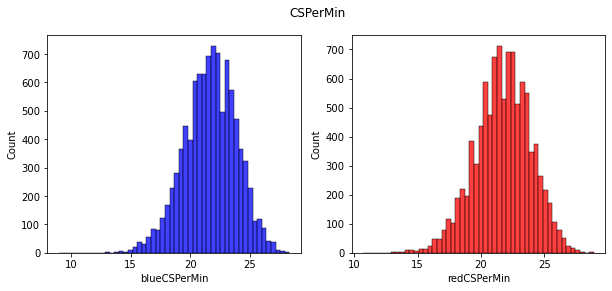

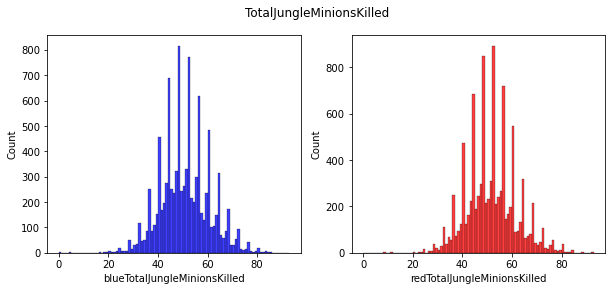

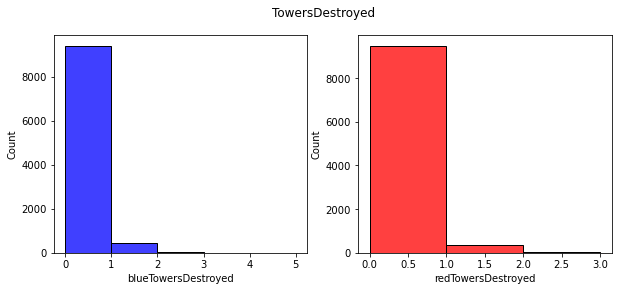

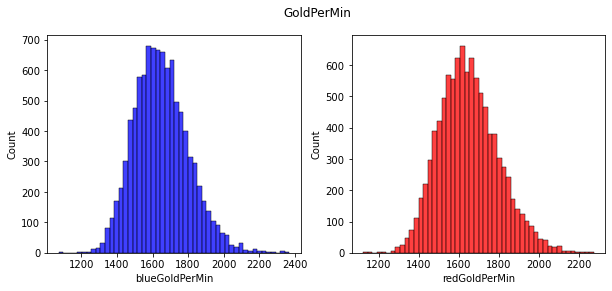

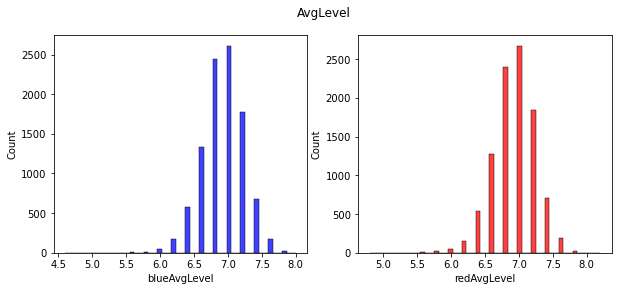

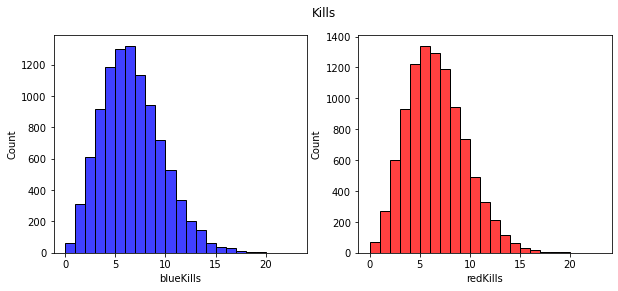

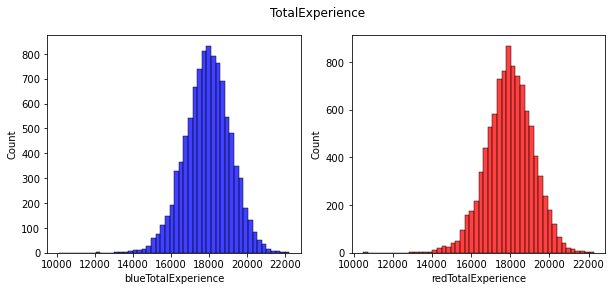

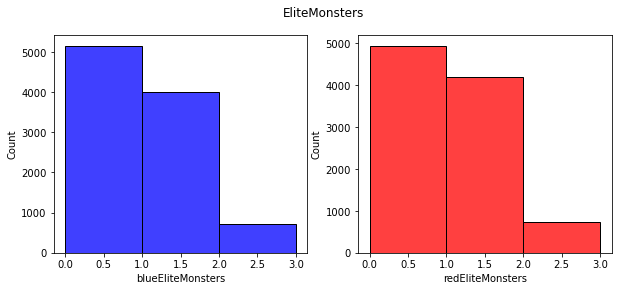

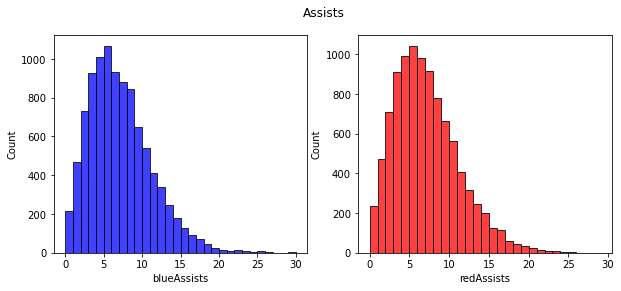

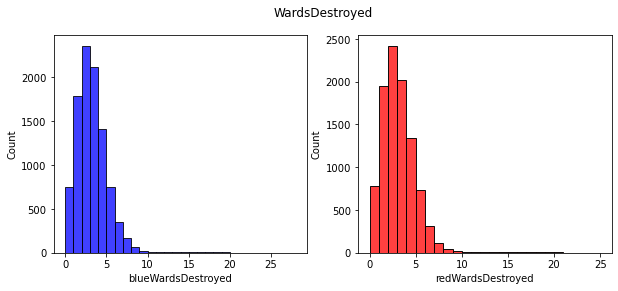

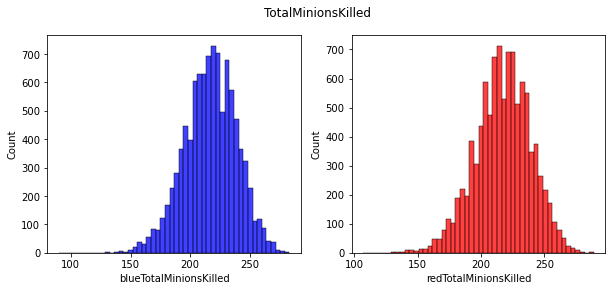

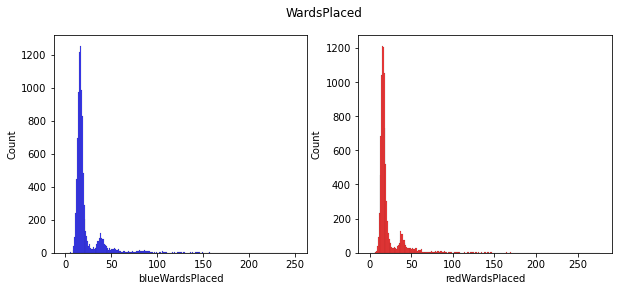

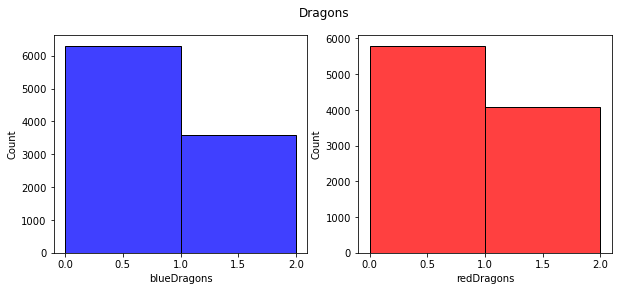

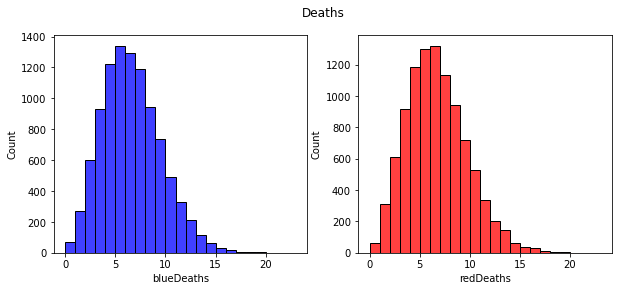

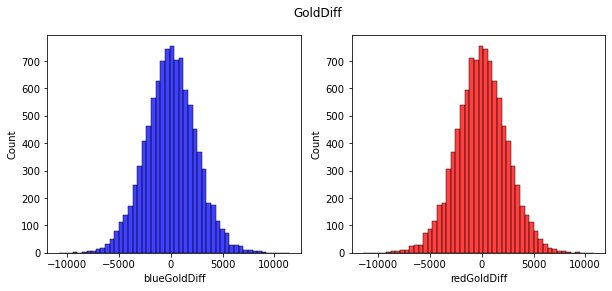

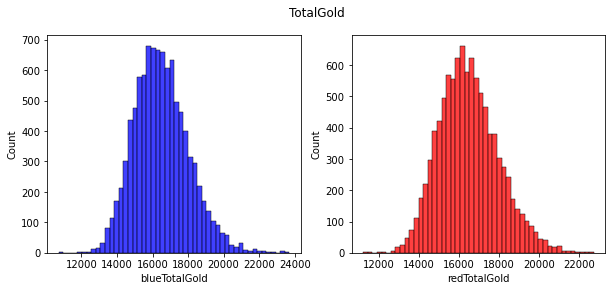

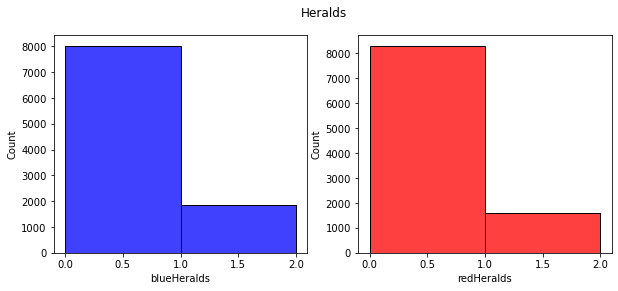

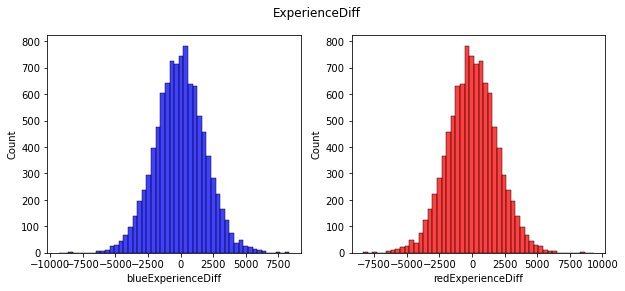

In [88]:
# get list of metrics without the features 
features = list(lol.drop(["blueWins", "blueFirstBlood", "redFirstBlood"], axis=1).columns)
features = list(set([col.replace("blue","").replace("red", "") for col in features]))

# look at histograms of each variable
def make_histograms(df: pd.DataFrame, features=features): 
    for col in features:
        fig, ax = plt.subplots(1, 2, figsize=(10, 4))
        
        if df["blue"+col].dtype == 'int64':
            sns.histplot(df["blue" + col], ax=ax[0], bins=np.arange(0, np.max(df["blue" + col])+2, 1), color="blue")
            sns.histplot(df["red" + col], ax=ax[1], bins=np.arange(0, np.max(df["red" + col])+2, 1), color="red")
        else:
            sns.histplot(df["blue" + col], ax=ax[0], bins=50, color="blue")
            sns.histplot(df["red" + col], ax=ax[1], bins=50, color="red")
        fig.suptitle(col)
        plt.show()  

# ad-hoc convert datatypes so a reasonable number of bins will be created
make_histograms(
    lol.drop(["blueWins", "blueFirstBlood"], axis=1).\
        astype({'blueTotalGold': np.float64, 
                'redTotalGold': np.float64,
                'blueTotalExperience': np.float64,
                'redTotalExperience': np.float64,
                'blueGoldDiff': np.float64,
                'redGoldDiff': np.float64,
                'blueExperienceDiff': np.float64,
                'redExperienceDiff': np.float64,
                'blueTotalMinionsKilled': np.float64,
                'redTotalMinionsKilled': np.float64,
               })
)

Scanning the histograms tells me that the only features that seem to have outliers have to do with wards.
Some games show 150+ wards in the first 10 minutes, or 15 wards per minute.
There are five players on a team, so each player is placing upwards of 3 wards per minute. While not impossible, this is certainly an agressive warding strategy. 
The maximum number of wards is 250; that would mean on average each player is placing 5 wards per minute!

You can place up to three wards at a time, and each ward lasts 2 minutes (unless destroyed beforehand). Assuming you are a diligent warder (and your enemies aren't destroying them), that means in the first 10 minutes you can place 15 wards, or 75 wards for a whole team. 
Using this heuristic, I will define an aggressive warding game as one where a team places twice as many as this amount, or more than 150 wards in the first 10 minutes. The reasoning behind doubling is to account for variability in the lifetime of a ward; most wards are found and destroyed, allowing you to place more than 3 wards every two minutes.
  


In [89]:
# aggressive_warders is a series of booleans indicating if the game is an aggressive warding game.
aggressive_warders = (lol["blueWardsPlaced"] > 150) | (lol["redWardsPlaced"] > 150)
print(f"There are {aggressive_warders.sum()} aggressive warding games, or about {100 * np.round(aggressive_warders.sum()/len(lol), 3)}% of games.")

There are 46 aggressive warding games, or about 0.5% of games.


Possible explanations for these aggressive warders (outliers) is that the Riot API counts wards from other sources. For example, the champion Fiddlesticks can obtain a trinket which lets him place more wards. This could account for the unusually high number of wards in some games, so I will leave the outliers in the dataset.
To deal with the heavy tail I will take the logarithm of this variable, which will make the distribution a bit more symmetric and force its values closer to zero.

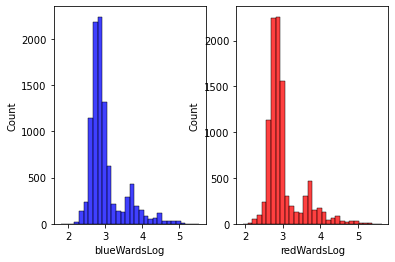

In [90]:
# take the logarithms of these variables. Adding 1 in case a game has zero wards placed.
lol["blueWardsLog"] = lol["blueWardsPlaced"].apply(lambda x: np.log(x+1))
lol["redWardsLog"] = lol["redWardsPlaced"].apply(lambda x: np.log(x+1))

# make a plot of them
fig, ax = plt.subplots(1, 2)

sns.histplot(lol["blueWardsLog"], ax=ax[0], bins=30, color="blue")
sns.histplot(lol["redWardsLog"], ax=ax[1], bins=30, color="red")
plt.show()

## Removing Highly Correlated Features

Some of the variables are redundant. These are often the variables that are of the form "total ---" and "--- per minute."
Since each game is 10 minutes in this dataset, these columns are going to be multiples of each other. An example of this is shown below in the case of total gold.

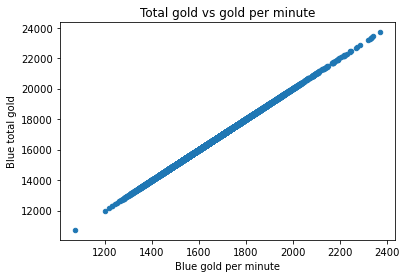

In [91]:
lol[["blueGoldPerMin", "blueTotalGold"]].plot.scatter(x="blueGoldPerMin", y="blueTotalGold")
plt.ylabel("Blue total gold")
plt.xlabel("Blue gold per minute")
plt.title("Total gold vs gold per minute")
plt.show()

In [92]:
# remove highly redundant features

# get correlation matrix
corr_mat = lol.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(np.bool))

# get columns to drop
cols_to_drop = [col for col in upper.columns if any(upper[col] > 0.99)]

# see which columns are highly correlated
corr_pairs = corr_mat.unstack().sort_values(ascending=False)
high_corrs = corr_pairs[corr_pairs > 0.95]
high_corrs.loc[(cols_to_drop, lol.columns.difference(cols_to_drop))]

blueCSPerMin       blueTotalMinionsKilled    1.0
blueGoldPerMin     blueTotalGold             1.0
redFirstBlood      blueFirstBlood            1.0
redKills           blueDeaths                1.0
redDeaths          blueKills                 1.0
redGoldDiff        blueGoldDiff              1.0
redExperienceDiff  blueExperienceDiff        1.0
redCSPerMin        redTotalMinionsKilled     1.0
redGoldPerMin      redTotalGold              1.0
dtype: float64

The above list shows pairs of columns that have perfect correlation. 
I will drop one column from each pair since they perfectly correlate with other features, which will reduce the dimensionality of the dataset.

In [93]:
lol.drop(columns=cols_to_drop, inplace=True)

## Total Gold is Redundant

From my experience playing this game I believe total gold should be determined by other features, such as 
minion kills/assists, champion kills, towers, and elite monsters. A simple linear model demonstrates this:

In [94]:
gold_fit = LinearRegression() 

# This is the subset of the data pertaining to gold income for blue team
gold_subset = lol[["blueTotalGold", "blueTotalJungleMinionsKilled", "blueKills","blueAssists", "blueEliteMonsters", "blueDragons", "blueHeralds", "blueTowersDestroyed", "blueTotalMinionsKilled"]]

gold_fit.fit(X=gold_subset.iloc[:, 1:], y=gold_subset["blueTotalGold"])

# R^2 value
R2 = gold_fit.score(X=gold_subset.iloc[:, 1:], y=gold_subset["blueTotalGold"])
print(f"This linear model has R^2 = {np.round(R2, 2)}.")

This linear model has R^2 = 0.94.


The reason this isn't perfect has to do with nuances in the kill-reward system; killing a champion rewards less and less the more they are killed, and a simple linear model will fail to detect this.

Let's take take a further look at the residuals:

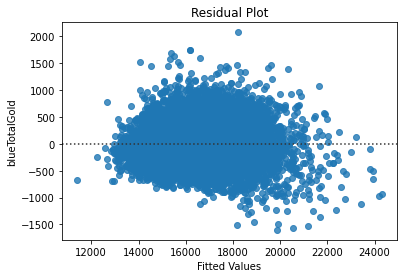

In [95]:
preds = gold_fit.predict(gold_subset.iloc[:, 1:])

sns.residplot(x=preds, y=gold_subset["blueTotalGold"])
plt.xlabel("Fitted Values")
plt.title("Residual Plot")
plt.show()

This is even more convincing evidence that total gold is a linear combination of other features.

## Unexpected Wins

Usually in a match of League of Legends, the more gold and kills ahead you are the more likely you are to win, 
unless something happens to turn the tides.
How often does this happen?
I will define an **unexpected win** as one where a team is down in kills by any amount in  the first 10 minutes.

In [96]:
# want rows where either red is down in kills AND wins, OR blue is down in kills and wins.

blue_unexpected_win = lol["blueWins"] & (lol["blueKills"] < lol["blueDeaths"])
red_unexpected_win = (1-lol["blueWins"]) & (lol["blueKills"] > lol["blueDeaths"]) 
unexpected_win = blue_unexpected_win | red_unexpected_win 

print(f"Number of unexpected wins: {unexpected_win.sum()}, or about {100*np.round(unexpected_win.sum()/len(lol),2)}% of games.")

Number of unexpected wins: 2441, or about 25.0% of games.


So, about a quarter of these diamond-ranked games have some kind of unexpected shift in favorability.
Can we see any early signs of this shift in the dataset?

To answer this I will examine unexpected blue wins by grouping the rows by expected/unexpected win and performing a t-test on each variable to determine which variables have a significant difference in mean between expected and unexpected games.
This is a series of hypothesis tests with null hypothesis that the mean $\mu_e$ of each feature for expected win outcome is the same as the mean $\mu_u$ for unexpected win outcome:

$H_0: \mu_e = \mu_u$
    
The alternative hypothesis is that these means are different:

$H_a: \mu_e \neq \mu_u$.
    
I employ a Bonferroni correction since there are many t-tests being done. For each team I will run as many t-tests as there are explanatory features, so I will correct by a factor of twice the number of explanatory features. 

In [97]:
# add these features to the dataframe
lol["blueWinExpectation"] = blue_unexpected_win.apply(lambda x: "unexpected" if x else "expected")
lol["redWinExpectation"] = red_unexpected_win.apply(lambda x: "unexpected" if x else "expected")

def t_test_table(data, team="blue"):
    team_col = team + "WinExpectation"

    # get each group in its own dataframe 
    unexpected_group = data.where(data[team_col] == "unexpected").dropna()
    expected_group = data.where(data[team_col] == "expected").dropna()  

    # perform a t test on each variable 
    t_test_results = {}
    cols = data.drop(["blueWinExpectation", "redWinExpectation", "blueWins"], axis=1)
    for col in cols:
        t_test_results[col] = scipy.stats.ttest_ind(expected_group[col], unexpected_group[col])

    # turn the t_test results into a dataframe
    ttest_df = pd.DataFrame.from_dict(t_test_results, orient='Index')

    # Take the means and transpose the dataframe to join it to the t test dataframe. 
    ttest_results = lol.groupby(by=[team_col]).\
        mean().\
        transpose().\
        join(ttest_df, how="inner")

    ttest_results.columns=["expected " + team + " win, mean",
                           "unexpected " + team + " win, mean",
                           "t statistic",
                           "p value"]

    # style function for significant p-values.
    # the Bonferroni correction is applied here.
    # the factor of 2 is there because this t_test function script is being run for each team.
    def color_significant(s, bonferroni_correction = 2 * len(ttest_df)):
        is_sig = s["p value"] < 0.05/bonferroni_correction 
        if is_sig:
            out = 'background-color: yellow'
        else:
            out = ''
        return [out for i in range(len(s))]
  
    # print the dataframe with a title
    return display(HTML(
        ttest_results.style.\
        set_caption("Significant features highlighted in yellow").\
        apply(color_significant, axis=1).render()))

t_test_table(lol, team="blue")

,"expected blue win, mean","unexpected blue win, mean",t statistic,p value
blueWardsPlaced,22.324648,22.026556,0.538080,0.590534
blueWardsDestroyed,2.841711,2.703734,2.063784,0.039064
blueFirstBlood,0.519599,0.398340,7.912933,0.000000
blueKills,6.382292,4.756017,17.848310,0.000000
blueDeaths,5.971178,7.336100,-15.310617,0.000000
blueAssists,6.873645,5.000000,15.167094,0.000000
blueEliteMonsters,0.550726,0.544398,0.329038,0.742134
blueDragons,0.363270,0.352697,0.715534,0.474296
blueHeralds,0.187457,0.191701,-0.353342,0.723839
blueTowersDestroyed,0.053493,0.036515,2.260448,0.023815


Some observations about this table:

* It shouldn't be surprising that we see significant differences in kills, deaths, assists, or gold since I defined unexpected wins as a difference in these values. 

*  This table shows that blue is behind in almost every significant metric (remember that blue deaths equals red kills; see the section on highly correlated variables above). This indicates that whatever event causes blue to unexpectedly win must happen after the 10 minute mark.

* The only exception to the previous point is in the number of jungle minions killed. However, the difference between the means is around one jungle minion; I would argue that this is an instance of a _statistically_ significant finding that is not _practically_ significant, since a few more jungle minions killed won't shift the tide of a game. The boxplot below further demonstrates this point by showing that the distribution of jungle minions killed is not significantly different for either group. 

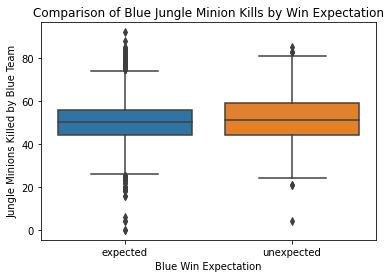

In [98]:
sns.boxplot(x="blueWinExpectation", y="blueTotalJungleMinionsKilled", data=lol)
plt.xlabel("Blue Win Expectation")
plt.ylabel("Jungle Minions Killed by Blue Team")
plt.title("Comparison of Blue Jungle Minion Kills by Win Expectation")
plt.show()

In [99]:
t_test_table(lol, team="red")

,"expected red win, mean","unexpected red win, mean",t statistic,p value
blueWardsPlaced,22.124147,23.436084,-2.394789,0.016648
blueWardsDestroyed,2.800995,2.991909,-2.887526,0.003891
blueFirstBlood,0.487794,0.623786,-8.979926,0.000000
blueKills,5.998959,7.477346,-16.362292,0.000000
blueDeaths,6.329747,4.794498,17.470991,0.000000
blueAssists,6.408423,8.300162,-15.489108,0.000000
blueEliteMonsters,0.548189,0.562298,-0.741666,0.458307
blueDragons,0.362953,0.355178,0.531950,0.594773
blueHeralds,0.185237,0.207120,-1.842005,0.065504
blueTowersDestroyed,0.052759,0.042071,1.438365,0.150362


The story is the same for the red team, which is to be expected. 

Overall I would say this table does not provide insight into unexpected wins, which answers the question posed earlier (can we see any early signs of unexpected win in the dataset?) in the negative.

# Predicting Wins

Can the winner be determined from the data obtained in the first 10 minutes of a game? Based on the analysis of unexpected wins above, it seems like any model built on this dataset to predict a winner will struggle with the unexpected wins. Let's try anyway.

Since the target variable `blueWins` is binary and the rest of the features are numeric, standard supervised learning models for binary classification will work well.
I will test logistic regression, K-nearest-neighbors, support vector machines, decision trees, and random forests. 

To test each model I will run a 5-fold cross-validation. To score a model I will look at accuracy, precision, recall, F1 score, and area under the ROC curve (roc_auc). Since the prediction is a game win, false positives and false negatives are not incredibly costly, so accuracy will be the main focus, with the others serving as backups.

In [100]:
# define the cross-validation splits so each model is trained on the same splits 
cv_folds = KFold(n_splits=5, shuffle=True, random_state=1)

def run_cv(model, X, y, folds=cv_folds):
    """
    This function runs cross validation on the given model and data.
    """ 
    return cross_validate(model, 
                          X, y, 
                          cv=folds,
                          scoring=["accuracy", "precision", "recall", "f1", "roc_auc"]
                         )
    
    
def view_cv_results(cv_results):
    """
    Converts the cross-validation results into a readable table.
    """ 
    # color map for values in the table
    cm = sns.light_palette("green", as_cmap=True)
    
    # make the dataframe from the input dict
    df = pd.DataFrame(cv_results)
    
    # reformatting the index column
    df["fold"] = pd.Series(["Fold " + str(i) for i in range(1, len(df)+1)])
    df.set_index("fold", inplace=True)
    df.index.name = None 
    
    return display(HTML(df.style.background_gradient(cmap=cm).render()))

def cv_conf_int(cv_results):
    """
    Uses the cross-validation results to create a confidence interval for each metric.
    """
    for metric in cv_results.keys():
        print(str(metric) + ": %0.2f (+/- %0.2f)" % (cv_results[metric].mean(), 2 * cv_results[metric].std()))

## Distance-Based Models


For these models it will be helpful to normalize the data since they work with Euclidean distances between data points.

In [101]:
# get numeric columns. 
# dropping total gold since it is a linear combo of other features (see section on total gold above).
# dropping WardsPlaced in favor of WardsLog.
numeric_cols = lol.drop(
    ["blueWins",
     "blueTotalGold",
     "redTotalGold",
     "blueWinExpectation",
     "redWinExpectation",
     "blueWardsPlaced",
     "redWardsPlaced"], axis=1).columns

# standardize the numeric columns
scaler = StandardScaler()
X = scaler.fit_transform(lol[numeric_cols])
y = lol["blueWins"]

### Logistic Regression

In [102]:
logreg = {}
logreg["model"] = LogisticRegression()  
logreg["results"] = run_cv(logreg["model"], X, y) 
view_cv_results(logreg["results"])

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
Fold 1,0.022971,0.006358,0.734312,0.725628,0.741273,0.733367,0.816178
Fold 2,0.022243,0.005840,0.742409,0.755352,0.733663,0.744350,0.819244
Fold 3,0.021512,0.006314,0.717611,0.735450,0.692921,0.713552,0.795920
Fold 4,0.023380,0.006259,0.726721,0.719475,0.731282,0.725331,0.806711
Fold 5,0.023485,0.005830,0.731139,0.720484,0.737603,0.728943,0.811005


In [103]:
cv_conf_int(logreg["results"])

fit_time: 0.02 (+/- 0.00)
score_time: 0.01 (+/- 0.00)
test_accuracy: 0.73 (+/- 0.02)
test_precision: 0.73 (+/- 0.03)
test_recall: 0.73 (+/- 0.04)
test_f1: 0.73 (+/- 0.02)
test_roc_auc: 0.81 (+/- 0.02)


### K-Nearest Neighbors

First let's identify an appropriate value for the number of neighbors.
For several random seeds I will make an 80/20 train/test split and plot accuracy on the test set for varying values of nearest neighbors.

In [104]:
# This cell is commented since it takes a while to run. Output is imported below.


# random_states = range(1, 10)
# k_values = range(1, 30)

# for rand_state in random_states:
    
#     # train/test split
#     X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rand_state, test_size=0.2)
    
#     # compute accuracies for varying values of n_neighbors
#     accuracies=[]
#     for j in k_values:
#         model = KNeighborsClassifier(n_neighbors=j)
#         model.fit(X_train, y_train) 
#         accuracies.append(model.score(X_test, y_test))

#     # add these accuracies to a plot
#     plt.plot(k_values, accuracies, alpha=0.4)
    
#     # add a vertical line for the maximum accuracy.
#     plt.vlines(x=np.argmax(accuracies)+1, ymin=min(accuracies), ymax=max(accuracies), linestyle="dashed")
    
# plt.xlabel("number of neighbors")
# plt.ylabel("test accuracy")
# plt.title("Test accuracy vs number of neighbors over random folds")
# plt.xticks(k_values[::2])
# plt.savefig("img/n_neighbors.jpg")

![alt_text](img/n_neighbors.jpg "Accuracies over different folds")

The vertical lines on the plot above indicate the locations of maximum test accuracy.
Seems like the best value for the number of neighbors is about 25; after this point the accuracy does not really improve. There is also a lot of variability in performance due to the choice of random seed.

In [105]:
knn = {}
knn["model"] = KNeighborsClassifier(n_neighbors=25)
knn["results"] = run_cv(knn["model"], X, y)
view_cv_results(knn["results"]) 

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
Fold 1,0.076871,1.259290,0.714575,0.705411,0.722793,0.713996,0.798444
Fold 2,0.029867,1.321600,0.717105,0.723489,0.722772,0.723130,0.791307
Fold 3,0.063684,1.226029,0.709008,0.727660,0.681954,0.704066,0.777453
Fold 4,0.057856,1.221938,0.712045,0.703000,0.721026,0.711899,0.788103
Fold 5,0.055042,1.207219,0.702278,0.698745,0.690083,0.694387,0.778877


In [106]:
cv_conf_int(knn["results"])

fit_time: 0.06 (+/- 0.03)
score_time: 1.25 (+/- 0.08)
test_accuracy: 0.71 (+/- 0.01)
test_precision: 0.71 (+/- 0.02)
test_recall: 0.71 (+/- 0.04)
test_f1: 0.71 (+/- 0.02)
test_roc_auc: 0.79 (+/- 0.02)


### Support vector machine

In [ ]:
svc = {}
svc["model"] = SVC(kernel="linear")
svc["results"] = run_cv(svc["model"], X, y)
view_cv_results(svc["results"])

In [ ]:
cv_conf_int(svc["results"])

## Non-Distance-Based Models

For these models, distances between datapoints are not going to affect the training process, so we can just use the unscaled data.

In [ ]:
# redefine X to get rid of the standardization
X = lol[numeric_cols]
y = lol["blueWins"]

### Decision Tree

This model is nice for interpretability. I will limit the depth of the tree to 3 to avoid overfitting.

In [ ]:
dectree = {}
dectree["model"] = DecisionTreeClassifier(random_state=1, max_depth=3)
dectree["results"] = run_cv(dectree["model"], X, y)
view_cv_results(dectree["results"])

In [ ]:
cv_conf_int(dectree["results"])

### Random Forest

In [ ]:
rfc = {}
rfc["model"] = RandomForestClassifier(max_depth = 3, n_estimators = 100)
rfc["results"] = run_cv(rfc["model"], X, y)
view_cv_results(rfc["results"])

In [ ]:
cv_conf_int(rfc["results"])

## Model Selection

Turns out most of these models perform similarly. The decision tree is about 1% less accurate than the best models (SVM, Logistic Regression, Random Forest), but the upshot is that it is very interpretable. 
Therefore I would recommend using the decision tree as a final model for prediction and drawing insight. 

Here is a plot of the decision tree trained on the whole dataset. This tree gives us a lot of information about how the model classifies a game.

In [ ]:
dectree["model"].fit(X, y)
plt.figure(figsize=(25,20))
plot_tree(dectree["model"], 
          feature_names = X.columns,
          class_names = ["Red Wins", "Blue Wins"],
          fontsize=20,
          filled=True
         )
plt.show()

We can learn a lot about this dataset from this tree.
*  The most important feature seems to be the gold difference between the teams. Once the gold difference exceeds about 1500, the team with the most gold is favored to win. (This is seen in the right-most and left-most branches above.)
* The next most important features seem to be the number of dragons slain (`redDragons`) and the experience difference (`blueExperienceDiff`). 
* It is likely random chance that one side of the tree has `blueExperienceDiff` and the other has `redDragons` as the second most important feature; I would not expect the color of the team to play into which of these two features determines the game. I believe this should be interpreted as saying that both factors can shift the tide when one team is behind in gold.

Having played a lot of League of Legends in my spare time, I can say that these results are very believable. If you asked professional players, I am sure they would say very similar things about who they expect to win early on.
Therefore, it is nice to see that the model confirms the intution.

## Unexpected wins and misclassification

Above I looked at games where one team unexpectedly won. How does the model classify these games? Put differently, do the misclassified games correspond with the unexpected wins? A simple group-by operation can inform us.

In [ ]:
# define a new column in the data to keep track of misclassified datapoints.
def is_correctly_classified(model, x, y):
    """
    return true or false for misclassified.
    """
    pred = model.predict(x.to_numpy().reshape(1, -1))[0]
    
    return y==pred

# feature for how each point was classified
lol["correctlyClassified"]=lol.apply(lambda x: is_correctly_classified(dectree["model"], x[numeric_cols], x["blueWins"]), axis=1)

# feature combining the win expectation variables
lol["winExpectation"] = unexpected_win.apply(lambda x: "unexpected" if x else "expected")

# group by these new features and calculate proportion of each class in the dataset
lol[["blueWins", "winExpectation", "correctlyClassified"]].\
    groupby(["winExpectation", "correctlyClassified"]).count()/len(lol)

This table shows the percentages of each combination of win expectation and classification, and it confirms that the decision tree gets more of the expected games correct (68%) than it does the unexpected games (20%).

This observation just about lines up with the prediction accuracy (72%).
Moreover, judging by the decision tree plot above, the most important factor for the model is the gold difference between the teams (followed by experience difference and dragon kills). 
Referring back to the yellow t-test tables above, this should be no surprise: there is a significant (both practical and statistical) difference in the gold difference between expected and unexpected games, so this classifier is going to struggle with predicting these unexpected wins. 

# Future Directions

From here it might be interesting to look at what's going on in those other two categories: 
those games where the expected-to-win team were misclassified by the model, and those games
where the underdog won and were correctly predicted to win.

Another possiblity for extending this project is to query the Riot API for more games or 
more features for the games studied in this dataset. How much of this holds true in lower-ranked games?

In a different vein, do different models misclassify different data points? If so, can boosting produce a more accurate model?